# Practice 05. Pagerank

In [1]:
import graphblas as gb
from graphblas import Matrix, Vector
from graphblas import unary, binary, monoid, semiring, dtypes

In [2]:
A = Matrix.from_coo(
    [0, 0, 1, 2, 2, 3, 4],
    [1, 2, 3, 3, 4, 4, 0],
    [1.1, 9.8, 4.2, 7.1, 0.2, 6.9, 2.2],
)
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

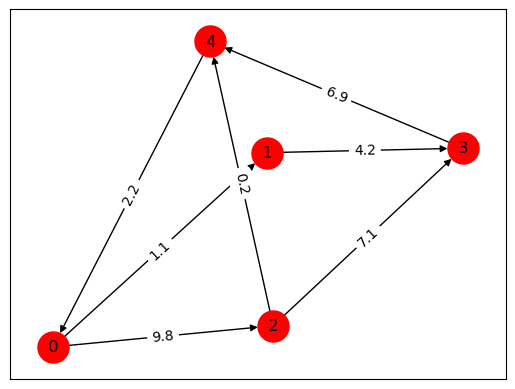

In [3]:
gb.viz.draw(A)

### Compare with C

Let's compare syntax from with the GraphBLAS C API.

This is an example from `LAGraph_pagerank3f`

```c++
GrB_Info LAGraph_pagerank3f // PageRank definition
(
    GrB_Vector *result,     // output: array of LAGraph_PageRank structs
    GrB_Matrix A,           // binary input graph, not modified
    GrB_Vector d_out,       // outbound degree of all nodes (not modified)
    float damping,          // damping factor (typically 0.85)
    int itermax,            // maximum number of iterations
    int *iters              // output: number of iterations taken
)
{

    //--------------------------------------------------------------------------
    // initializations
    //--------------------------------------------------------------------------

    GrB_Info info ;
    GrB_Index n ;
    GrB_Vector r = NULL, d = NULL, t = NULL, w = NULL ;
    (*result) = NULL ;
    LAGr_Matrix_nrows (&n, A) ;
    GrB_Descriptor desc_t0 = GrB_DESC_T0 ;

    const float teleport = (1 - damping) / n ;
    const float tol = 1e-4 ;
    float rdiff = 1 ;       // first iteration is always done

    // r = 1 / n
    LAGr_Vector_new (&t, GrB_FP32, n) ;
    LAGr_Vector_new (&r, GrB_FP32, n) ;
    LAGr_Vector_new (&w, GrB_FP32, n) ;
    LAGr_assign (r, NULL, NULL, 1.0 / n, GrB_ALL, n, NULL) ;

    // prescale with damping factor, so it isn't done each iteration
    // d = d_out / damping ;
    LAGr_Vector_dup (&d, d_out) ;
    LAGr_assign (d, NULL, GrB_DIV_FP32, damping, GrB_ALL, n, NULL) ;

    //--------------------------------------------------------------------------
    // pagerank iterations
    //--------------------------------------------------------------------------

    for ((*iters) = 0 ; (*iters) < itermax && rdiff > tol ; (*iters)++)
    {
        // swap t and r ; now t is the old score
        GrB_Vector temp = t ; t = r ; r = temp ;

        // w = t ./ d
        LAGr_eWiseMult (w, NULL, NULL, GrB_DIV_FP32, t, d, NULL) ;

        // r = teleport
        LAGr_assign (r, NULL, NULL, teleport, GrB_ALL, n, NULL) ;

        // r += A'*w
        LAGr_mxv (r, NULL, GrB_PLUS_FP32, GxB_PLUS_SECOND_FP32, A, w, desc_t0) ;

        // t -= r
        LAGr_assign (t, NULL, GrB_MINUS_FP32, r, GrB_ALL, n, NULL) ;

        // t = abs (t)
        LAGr_apply (t, NULL, NULL, GxB_ABS_FP32, t, NULL) ;

        // rdiff = sum (t)
        LAGr_reduce (&rdiff, NULL, GxB_PLUS_FP32_MONOID, t, NULL) ;
    }
```

In [4]:
def pagerank_3f(A, d_out, damping=0.85, itermax=100, tol=1e-4):
    """
    Returns (result as Vector, iters as int)
    """
    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # r = 1 / n
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] << 1.0 / n

    # prescale with damping factor, so it isn't done each iteration
    # d = d_out / damping
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping

    # --------------------------------------------------------------------------
    # pagerank iterations
    # --------------------------------------------------------------------------
    for i in range(itermax):
        if rdiff <= tol:
            break

        # swap t and r ; now t is the old score
        r, t = t, r

        # w = t ./ d
        w << t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] << teleport

        # r += A'*w
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        # t -= r
        t(binary.minus)[:] << r

        # t = abs (t)
        t << t.apply(unary.abs)

        # rdiff = sum (t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

In [5]:
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

In [6]:
# Pagerank requires binary input graph
A << A.apply(unary.one)
A

"M_0"      nvals  nrows  ncols  dtype         format
gb.Matrix      7      5      5   FP64  bitmapr (iso)
----------------------------------------------------
     0    1    2    3    4
0       1.0  1.0          
1                 1.0     
2                 1.0  1.0
3                      1.0
4  1.0

In [7]:
# Compute outbound degree of nodes
d_out = A.reduce_rowwise(monoid.plus).new()
d_out

"v_0"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index    0    1    2    3    4
value  2.0  1.0  2.0  1.0  1.0

In [8]:
result, iters = pagerank_3f(A, d_out)

In [9]:
result

"v_1"      nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index         0         1         2         3         4
value  0.254212  0.138031  0.138031  0.205973  0.263752

In [10]:
iters

37

### Compare with networkx for accuracy

In [11]:
import networkx as nx

g = gb.io.to_networkx(A)
g.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 0)])

In [12]:
nx.pagerank(g, tol=1e-4)

{0: 0.2542370526098617,
 1: 0.13807850431853438,
 2: 0.13807850431853438,
 3: 0.2059371902920227,
 4: 0.2636687484610469}

### Compare with networkx for speed

Need a larger graph for this test

In [13]:
big = nx.erdos_renyi_graph(1000, 0.04, directed=True)

In [14]:
%%timeit
pr = nx.pagerank(big, tol=1e-6)

13.4 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
B = gb.io.from_networkx(big, dtype="UINT8")
B

"M_1"      nvals  nrows  ncols  dtype     format
gb.Matrix  39834   1000   1000  UINT8  csr (iso)
------------------------------------------------
     row  col  val
0      0   75    1
1      0  103    1
2      0  184    1
3      0  232    1
4      0  234    1
5      0  237    1
6      0  323    1
7      0  346    1
8      0  352    1
9      0  358    1
...  ...  ...  ...

In [16]:
%%timeit
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

705 µs ± 5.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
# timeit doesn't save variables, so recompute
pr = nx.pagerank(big, tol=1e-6)
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

In [18]:
iter

7

In [19]:
results

"v_40561"  nvals  size  dtype  format
gb.Vector   1000  1000   FP32    full
-------------------------------------
index       0         1         2         3         4         5         6    \
value  0.000929  0.000882  0.001035  0.000878  0.001103  0.001025  0.001113   

index       7        8         9    ...       990       991       992  \
value  0.001071  0.00109  0.000844  ...  0.001007  0.001001  0.000912   

index       993       994       995       996    997       998       999  
value  0.000862  0.001025  0.001057  0.001175  0.001  0.001098  0.000918

In [20]:
# Only look at first 10 results from networkx
{k: v for k, v in pr.items() if k < 10}

{0: 0.0009289892362295132,
 1: 0.0008815110128540986,
 2: 0.0010349796154918447,
 3: 0.000878183337853016,
 4: 0.0011028315315945705,
 5: 0.0010246587492484503,
 6: 0.0011130191158820943,
 7: 0.001070690259898533,
 8: 0.0010898157695906315,
 9: 0.0008442121620818434}

In [21]:
# Verify all results match
all(abs(results[i].value - pr[i]) < 1e-5 for i in range(1000))

True